<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Qichen(Lead), Paritosh, Rawal, Yan, Zen, Wen-Hsuan

## Q4 Extract Text from Images (35 points)

**Please include all the write up answers below to theory.ipynb. For the questions need code, you need to include the screenshot of code to theory.ipynb to get points.**

![](figures/annotatedLetters.jpg)
<center>Sample image with handwritten characters annotated with boxes around each character</center>

Now that you have a network that can recognize handwritten letters with reasonable accuracy, you can now use it to parse text in an image. Given an image with some text on it, our goal is to have a function that returns the actual text in the image. However, since your neural network expects a a binary image with a single character, you will need to process the input image to extract each character. There are various approaches that can be done so feel free to use any strategy you like.

Here we outline one possible method, another is that given in a [tutorial](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)
1. Process the image ([blur](http://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html), [threshold](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.try_all_threshold), [opening morphology](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.opening), etc. (perhaps in that order)) to classify all pixels as being part of a character or background.
2. Find connected groups of character pixels (see [skimage.measure.label](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label)). Place a bounding box around each connected component.
3. Group the letters based on which line of the text they are a part of, and sort each group so that the letters are in the order they appear on the page.
4. Take each bounding box one at a time and resize it to $32\times 32$, classify it with your network, and report the characters in order (inserting spaces when it makes sense).

Since the network you trained likely does not have perfect accuracy, you can expect there to be some errors in your final text parsing. Whichever method you choose to implement for the character detection, you should be able to place a box on most of there characters in the image. We have provided you with **01\_list.jpg**, **02\_letters.jpg**, **03\_haiku.jpg** and **04\_deep.jpg** to test your implementation on.

### Q4.1 (3 points WriteUp)
The method outlined above is pretty simplistic, and makes several assumptions. What are two big assumptions that the sample method makes. In your writeup, include two example images where you expect the character detection to fail (either miss valid letters, or respond to non-letters).

<font color="red">**Please include the write up answer to theory.ipynb**</font>

### Q4.2 (13 points Code+WriteUp)
Find letters in the image. Given an RGB image, this function should return bounding boxes for all of the located handwritten characters in the image, as well as a binary black-and-white version of the image \texttt{im}. Each row of the matrix should contain **[y1,x1,y2,x2]** the positions of the top-left and bottom-right corners of the box. The black and white image should be floating point, 0 to 1, with the characters in black and background in white. 

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


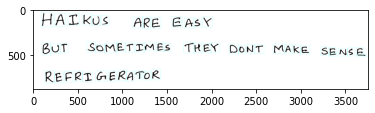

In [1]:
import numpy as np
import functools

import skimage
import skimage.measure
import skimage.color
import skimage.restoration
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.segmentation

import matplotlib.pyplot as plt

def sort_key(item1, item2):
    line_thres = 150
    word_thres = 150

    if abs(item1[0] - item2[0]) < line_thres:
        return item1[1] - item2[1]
    
    return item1[0] - item2[0]
    

# takes a color image
# returns a list of bounding boxes and black_and_white image
def findLetters(image):
    bboxes = []
    bw = skimage.color.rgb2gray(image)
    # insert processing in here
    bw = skimage.restoration.denoise_tv_chambolle(bw)
    bw = skimage.morphology.opening(bw)
    bw = skimage.morphology.closing(bw)
    thres = skimage.filters.threshold_isodata(bw)
    
    background = bw >= thres
    foreground = bw < thres
    bw[foreground] = 0
    bw[background] = 1
    
    lab_bw = skimage.measure.label(bw, 1)
    expanded = skimage.segmentation.expand_labels(lab_bw, distance=10)
    regionprops = skimage.measure.regionprops(expanded)
    bboxes = [region.bbox for region in regionprops if region.area > (2 * 1024)]
    bboxes = sorted(bboxes, key=functools.cmp_to_key(sort_key))
    
    return bboxes, bw

image = skimage.io.imread('images/03_haiku.jpg')
bboxes, bw = findLetters(image)

bw_marked = np.stack((bw, bw, bw), axis=-1)

for i in bboxes:
    rr, cc = skimage.draw.rectangle_perimeter((i[0], i[1]), (i[2], i[3]), shape=bw_marked.shape[:2])
    bw_marked[rr, cc] = [0, 255, 255]


plt.imshow(bw_marked, cmap='gray')
plt.show()

### Q4.3 (6 points Code+WriteUp)
Run `findLetters()` on all of the provided sample images in **images/**. Plot all of the located boxes on top of the image to show the accuracy of your `findLetters()` function. Include all the result images in your writeup.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

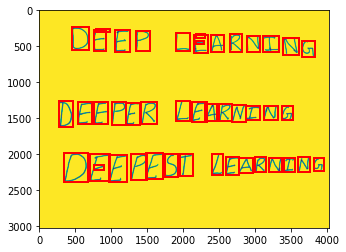

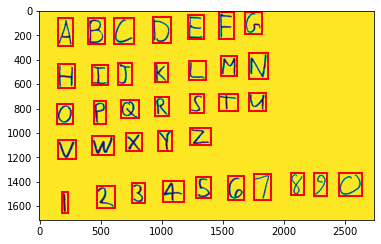

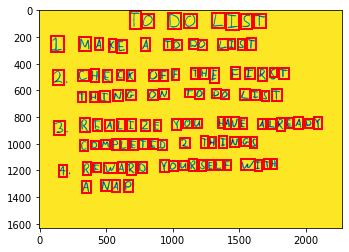

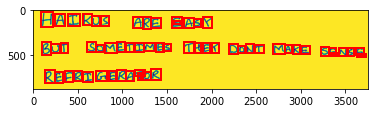

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches

from ipynb.fs.defs.q2 import *

# do not include any more libraries here!
# no opencv, no sklearn, etc!
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

def get_patches(img_path, size=32, transpose=True):
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images',img_path)))
    bboxes, bw = findLetters(im1)

    plt.imshow(bw)
    for bbox in bboxes:
        minr, minc, maxr, maxc = bbox
        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    plt.show()
    
    patches = []

    for bbox in bboxes:
        patch = np.pad(bw[bbox[0]: bbox[2], bbox[1]: bbox[3]], 20, mode='edge')        
        patch = skimage.transform.resize(patch, (size, size))
        patch = 1 - skimage.morphology.dilation(1. - patch)
            
        if transpose:
            patch = patch.T
    
        patches.append(patch.flatten())
    
    patches = np.vstack(patches)
    
    return patches, bboxes

for img in os.listdir('images'):
    _ = get_patches(img)

### Q4.4 (13 points Code+WriteUp)
Now you will load the image, find the character locations, classify each one with the network you trained in **Q3.1**, and return the text contained in the image. Be sure you try to make your detected images look like the images from the training set. Visualize them and act accordingly. 

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

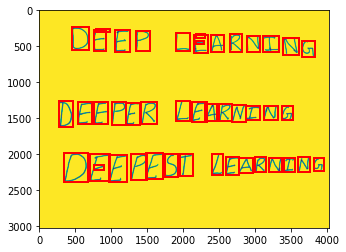

D HM E P L KMM A R M I N G
D E E P E R L E A R N I N G
D E K P 8 S T L
V E A R N I N G


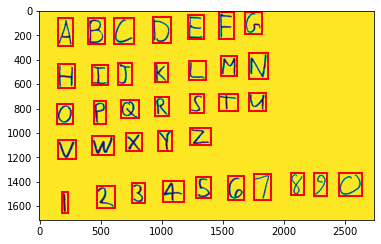

A B C D E F G
H I J K L M N
0 P Q R S T U
V W X Y Z
8 Z 3 4 S G 7 8 9 0


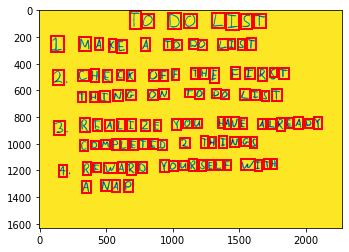

T0 D0 LIST
2 MAKE A TODO LIST
2 CHRCK OFE YHE FIRKT
YHING ON TODO LXST
3 RKA HAV
C PLI
M L TZE Y2OU
O E DD Y4INERSALREARY
4 ARLNWAAPRD YOURSELF WIYH


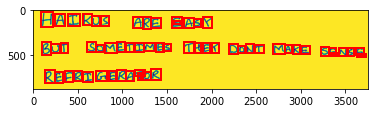

H A I KUS ARE EAASX
BUT SQMETIMES TH5X DONT MAKR S64NS64
REFRI GERACYDR


In [4]:
# load the weights
# run the crops through your neural network and print them out
import pickle
import string
import numpy as np

params = pickle.load(open('q3_weights.pickle','rb'))

def show_sentences(patches, bboxes, characters, line_thres=150, word_thres=130):
    res = str(characters[0])

    for i in range(1, len(characters)):
        if (abs(bboxes[i][0] - bboxes[i - 1][0]) > line_thres):
            res += '\n'
        elif (abs((bboxes[i][3] + bboxes[i][1]) / 2 - (bboxes[i - 1][3] + bboxes[i - 1][1]) / 2) > word_thres):
            res += ' '

        res += characters[i]

    print(res)

for img in os.listdir('images'):
    patches, bboxes = get_patches(img)
    
    # Network
    a1 = forward(patches, params, name='layer1')
    y_probs = forward(a1, params, name='output', activation=softmax)
    
    y = np.argmax(y_probs, axis=1)
    y[y < 26] += 65
    y[y < 36] += (48 - 26)
    
    show_sentences(patches, bboxes, [chr(y[i]) for i in range(len(y))])